<a href="https://colab.research.google.com/github/mvsakrishna/AIM-5001/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:

!pip install tensorflow keras pillow numpy tqdm

Import all required libraries

In [5]:
from PIL import Image
from pickle import dump, load


from tensorflow.keras.applications.xception import Xception, preprocess_input

# used to handle files using system commands
import os
import string

# used to store numpy features extracted
# used to perform a wide variety of mathematical operations on arrays
import pickle
import numpy as np

# to have UI for data processed information and progress bar decorator for iterators. Includes a default range iterator printing to stderr.
from tqdm.notebook import tqdm

# used for loading the image and converting the image to a numpy array
# used for loading the text as convert them into a token
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

# used for equal distribution of words in sentences filling the remaining spaces with zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model

# used to visualize the architecture of the model through different images
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
# data cleaning

# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [7]:
# Paths for dataset and images
dataset_text = "/content/drive/MyDrive/Image_Caption_project/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset"

# Prepare text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = all_img_captions(filename)
print("Length of descriptions =", len(descriptions))

clean_descriptions = cleaning_text(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

save_descriptions(clean_descriptions, "/content/drive/MyDrive/Image_Caption_project/captions.txt")

Length of descriptions = 8092
Length of vocabulary = 8763


Extracting the feature vector from all images

In [8]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("/content/drive/MyDrive/Image_Caption_project/features.p","wb"))

83683744/83683744 [==============================] - 0s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 344ms/step


In [9]:
features = load(open("/content/drive/MyDrive/Image_Caption_project/features.p","rb"))

Loading dataset for Training the model

In [10]:
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/Image_Caption_project/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/Image_Caption_project/captions.txt", train_imgs)
train_features = load_features(train_imgs)

Tokenizing the vocabulary

In [11]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/Image_Caption_project/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [12]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

Create Data generator

In [13]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((37, 2048), (37, 32), (37, 7577))

((37, 2048), (37, 32), (37, 7577))

Defining the CNN-RNN model

In [14]:
# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/Image_Caption_project/model.png', show_shapes=True)

    return model

Training

In [15]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
print(model, 'model')
epochs = 3
steps = len(train_descriptions)
models_dir = "/content/drive/MyDrive/Image_Caption_project/models"

# Check if the directory exists; if not, create it
if not os.path.exists(models_dir):
    os.mkdir(models_dir)
else:
    print("Directory already exists.")

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(os.path.join(models_dir, "model_" + str(i) + ".h5"))

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 256)              1939712   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]'] 

<ipython-input-15-c680a11a5ab0>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 1470s 244ms/step - loss: 4.8986


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6000/6000 [==============================] - 1456s 243ms/step - loss: 3.6168


In [43]:
# After training
model.save_weights(os.path.join(models_dir, "model_weights.h5"))

# To load the saved weights and evaluate the model
# Load the model architecture first
model = define_model(vocab_size, max_length)

# Load the saved weights
model.load_weights(os.path.join(models_dir, "model_weights.h5"))

# Now you can evaluate the model on the training data or perform any other operations
# Example:
# Evaluation on training data (for demonstration purposes)
train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
# Evaluate the model on the training data
evaluation = model.evaluate(train_generator, steps=len(train_descriptions), verbose=1)
print("Evaluation Loss:", evaluation)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 256)              1939712   ['input_7[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 2048)                 0         ['input_6[0][0]']             
                                                                                            

In [54]:
# Load your trained model and weights
model = define_model(vocab_size, max_length)
model.load_weights(os.path.join(models_dir, "model_weights.h5"))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 32)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 32, 256)              1939712   ['input_13[0][0]']            
                                                                                                  
 dropout_10 (Dropout)        (None, 2048)                 0         ['input_12[0][0]']            
                                                                                            

TEST THE MODEL USING DUMMY FOLLOWING IMAGE

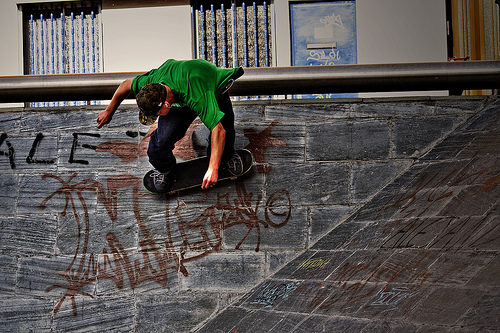

In [37]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/142802798_962a4ec5ce.jpg')
imagePath = '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/142802798_962a4ec5ce.jpg'
img = Image.open(imagePath)
img

In [38]:
!python3 '/content/drive/MyDrive/Image_Caption_project/testing_caption_generator.py' -i '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/142802798_962a4ec5ce.jpg'

2023-12-18 17:15:47.891517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 17:15:47.891597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 17:15:47.893422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 17:15:49.599183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 1s/step



start of skateboarder is jumping off the wall of the side of the street in the background of the sun in the background are sitting on the wall with the camera in the


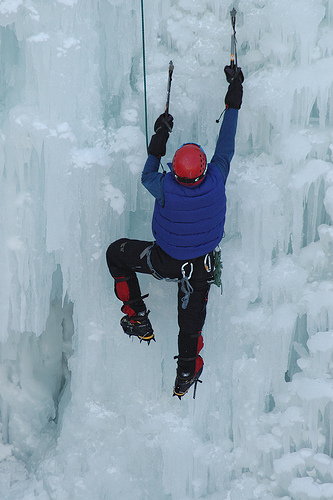

In [112]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg')
imagePath = '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg'
img = Image.open(imagePath)
img

In [113]:
!python3 '/content/drive/MyDrive/Image_Caption_project/testing_caption_generator.py' -i '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg'

2023-12-18 19:12:33.480803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 19:12:33.480941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 19:12:33.659859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 19:12:37.528461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 1s/step



start of people are standing on the ground with red and white sky in the background in the background are standing on the ground with the mountains in the background is standing on


In [114]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

def generate_caption(model, tokenizer, max_length, image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Generate the caption using the model
    caption = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = np.argmax(model.predict([image, sequence], verbose=0))
        word = word_for_id(prediction, tokenizer)
        if word is None:
            break
        caption += ' ' + word
        if word == 'endseq':
            break
    return caption

In [117]:
import pickle
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

# Load the tokenizer from the saved file
with open('/content/drive/MyDrive/Image_Caption_project/tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)

# Load the trained model
trained_model = load_model('/content/drive/MyDrive/Image_Caption_project/models/final_model.h5')  # Replace with the path to your trained model file

# Load the Xception model (without the fully connected layers)
xception_model = Xception(include_top=False, pooling='avg')

def generate_caption(model, tokenizer, max_length, image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((299, 299))
    image = np.asarray(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    # Extract features from the image using the Xception model
    image_features = xception_model.predict(image)

    # Generate the caption using the model
    caption = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = np.argmax(model.predict([image_features, sequence], verbose=0))
        word = tokenizer.index_word[prediction]
        if word is None or word == 'endseq':
            break
        caption += ' ' + word
    return caption

# Provide image paths
image_paths = [
    '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg',
    '/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/54501196_a9ac9d66f2.jpg'
]  # Replace with your image paths

# Generate captions for each image
for image_path in image_paths:
    caption = generate_caption(trained_model, tokenizer, max_length, image_path)
    print(f"Generated Caption for {image_path}: {caption}")


1/1 [==============================] - 2s 2s/step
Generated Caption for /content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg: startseq in the snow with mountains in the background in the background in the background in the background in the background are in the background are walking on the snow with mountains in
1/1 [==============================] - 0s 350ms/step
Generated Caption for /content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/54501196_a9ac9d66f2.jpg: startseq mountain climber is standing on the mountain in the mountains in the mountains in the background mountains in the background in the mountains in the background mountains in the background in the


In [134]:
# List to store ground truth and generated captions
reference_captions = [
    'A man uses ice picks and crampons to scale ice',
    'an ice climber in a blue jacket and black pants is scaling a frozen ice wall',
    'An ice climber scaling a frozen waterfall',
    'A person in blue and red ice climbing with two picks',
    'Climber climbing an ice wall'
]
generated_captions = []

# Process each test image and generate captions
test_image_paths = ['/content/drive/MyDrive/Image_Caption_project/Flickr8k_Dataset/102455176_5f8ead62d5.jpg']  # Paths to your test images

for image_path in test_image_paths:
    # Generate caption using your trained model (assuming you've loaded the model)
    caption = generate_caption(trained_model, tokenizer, max_length, image_path)

    # Append the generated caption
    generated_captions.append(caption)


# Print or save the generated and reference captions
print("Generated Captions:", generated_captions)

1/1 [==============================] - 0s 332ms/step
Generated Captions: ['startseq in the snow with mountains in the background in the background in the background in the background in the background are in the background are walking on the snow with mountains in']


In [137]:
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.meteor_score import Meteor
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# List to store ground truth and generated captions
reference_captions = [
    'A man uses ice picks and crampons to scale ice',
    'an ice climber in a blue jacket and black pants is scaling a frozen ice wall',
    'An ice climber scaling a frozen waterfall',
    'A person in blue and red ice climbing with two picks',
    'Climber climbing an ice wall'
]

# Replace 'Your generated caption here' with your actual generated caption
generated_caption = 'startseq in the snow with mountains in the background in the background in the background in the background in the background are in the background are walking on the snow with mountains in'

# Create a list by repeating the generated caption 5 times
generated_captions = [generated_caption] * 5

# Tokenize generated and reference captions
reference_tokenized = [word_tokenize(caption.lower()) for caption in reference_captions]
generated_tokenized = [word_tokenize(caption.lower()) for caption in generated_captions]

# Ensure the number of generated captions matches the number of reference captions
if len(generated_captions) != len(reference_captions):
    print("Number of generated captions does not match the number of reference captions.")
else:
    # Compute BLEU and METEOR scores
    bleu_scores = []
    meteor_scores = []

    for i in range(len(reference_captions)):
        # Calculate BLEU score
        bleu_score = sentence_bleu([reference_tokenized[i]], generated_tokenized[i])
        bleu_scores.append(bleu_score)

        # Calculate METEOR score
        meteor_scr = meteor_score([reference_tokenized[i]], generated_tokenized[i])
        meteor_scores.append(meteor_scr)

    # Print the scores
    print(f"BLEU Scores: {bleu_scores}")
    print(f"METEOR Scores: {meteor_scores}")

    # Calculate average BLEU and METEOR scores
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_meteor_score = sum(meteor_scores) / len(meteor_scores)

    print(f"Average BLEU Score: {avg_bleu_score}")
    print(f"Average METEOR Score: {avg_meteor_score}")

BLEU Scores: [0, 7.601159375410181e-232, 0, 9.039352811507815e-232, 0]
METEOR Scores: [0.0, 0.02824858757062147, 0.0, 0.07575757575757576, 0.0]
Average BLEU Score: 3.328102437383599e-232
Average METEOR Score: 0.020801232665639446
